In [666]:
import sys
sys.path.append('../../30_data_tools/')

from helper import load_dotenv
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
import math
import plotly.express as px
from scipy.ndimage import gaussian_filter
from random import randrange, choices, shuffle
from tqdm.auto import tqdm
import json
from skimage.metrics import structural_similarity as ssim

In [556]:
def get_fft( input_img ):
    ft = np.fft.ifftshift(np.array(input_img))
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    return ft

def limit_frequencies( fft, inner_limit=None, outer_limit=None ):
    center = (fft.shape[1] / 2, fft.shape[0] / 2)
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r = math.sqrt( abs(center[0] - x) ** 2 + abs(center[1] - y) ** 2 )
            
            if outer_limit is not None and r > outer_limit:
                fft[y,x] = 1
    
            if inner_limit is not None and r < inner_limit:
                fft[y,x] = 1

    return fft


def get_frequency_gain( orig_img, synthetic_img, additional=.00001 ):
    fft_orig = get_fft( orig_img )
    fft_synthetic = get_fft( synthetic_img )

    res = np.log( (np.abs(fft_orig) ** 2 + additional) / (np.abs(fft_synthetic) ** 2 + additional) )
    res = limit_frequencies( res, outer_limit=70 )
    res = gaussian_filter(res, sigma=3)

    return res


def get_diff_img_frequency_gain( orig_img, synthetic_img ):
    diff_img = Image.fromarray(gaussian_filter(np.array(synthetic_img) - np.array(orig_img),sigma=3))
    fft = np.abs( limit_frequencies( get_fft(diff_img), inner_limit=5 ) )
    fft = gaussian_filter(fft, sigma=3)

    return fft

In [2]:
dotenv = load_dotenv()

In [701]:
moire_tiles = list((dotenv['TILE_DATASET_DIR'] / 'train' / 'moire').glob('./*.jpg'))

# Auszeichnung

In [702]:
moire = []
no_moire = []

In [703]:
selection = choices([i for i in range(len(moire_tiles))], k=25)

In [704]:
i = 0

In [755]:
moire_tile_path = moire_tiles[selection[i]]
non_moire_tile_path = moire_tile_path.parent.parent / 'no_moire' / moire_tile_path.name
moire_tile = Image.open( moire_tile_path ).convert('L')
non_moire_tile = Image.open( non_moire_tile_path ).convert('L')
display_img = Image.new('L',(moire_tile.size[0] + non_moire_tile.size[0],max([moire_tile.size[1],non_moire_tile.size[1]])), color="white")
display_img.paste(
    moire_tile,
    (0,0)
)
display_img.paste(
    non_moire_tile,
    (moire_tile.size[0],0)
)
i += 1

display_img

IndexError: list index out of range

In [754]:
moire.append(moire_tile_path.name.replace(moire_tile_path.suffix,''))

In [752]:
no_moire.append(moire_tile_path.name.replace(moire_tile_path.suffix,''))

In [ ]:
0 / 0

In [756]:
with Path('./tile_classification.json').open() as json_file:
    check_data = json.load( json_file )

with Path('./tile_classification.json').open('w') as json_file:
    json_file.write(
        json.dumps({
            'moire' : check_data['moire'] + moire,
            'no_moire' : check_data['no_moire'] + no_moire
        })
    )

# Hypothesentest

In [757]:
with Path('./tile_classification.json').open() as json_file:
    check_data = json.load( json_file )

In [758]:
out_moire = []

for moire_tile_name in tqdm(check_data['moire']):
    moire_tile_path = dotenv['TILE_DATASET_DIR'] / 'train' / 'moire' / f"{moire_tile_name}.jpg"
    non_moire_tile_path = moire_tile_path.parent.parent / 'no_moire' / moire_tile_path.name
    moire_tile = Image.open( moire_tile_path ).convert('L')
    non_moire_tile = Image.open( non_moire_tile_path ).convert('L')
    frequency_gain = get_frequency_gain( moire_tile, non_moire_tile ).max()
    frequency_gain_invert = get_frequency_gain( ImageOps.invert(moire_tile), ImageOps.invert(non_moire_tile) ).max()
    ssim_value = ssim( np.array(moire_tile), np.array(non_moire_tile) )

    out_moire.append((
        i,
        moire_tile,
        non_moire_tile,
        frequency_gain,
        frequency_gain_invert,
        ssim_value,
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).max(),
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).mean(),
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).std()
    ))


out_no_moire = []

for moire_tile_name in tqdm(check_data['no_moire']):
    moire_tile_path = dotenv['TILE_DATASET_DIR'] / 'train' / 'moire' / f"{moire_tile_name}.jpg"
    non_moire_tile_path = moire_tile_path.parent.parent / 'no_moire' / moire_tile_path.name
    moire_tile = Image.open( moire_tile_path ).convert('L')
    non_moire_tile = Image.open( non_moire_tile_path ).convert('L')
    frequency_gain = get_frequency_gain( moire_tile, non_moire_tile ).max()
    frequency_gain_invert = get_frequency_gain( ImageOps.invert(moire_tile), ImageOps.invert(non_moire_tile) ).max()
    ssim_value = ssim( np.array(moire_tile), np.array(non_moire_tile) )

    out_no_moire.append((
        i,
        moire_tile,
        non_moire_tile,
        frequency_gain,
        frequency_gain_invert,
        ssim_value,
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).max(),
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).mean(),
        get_diff_img_frequency_gain( moire_tile, non_moire_tile ).std()
    ))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

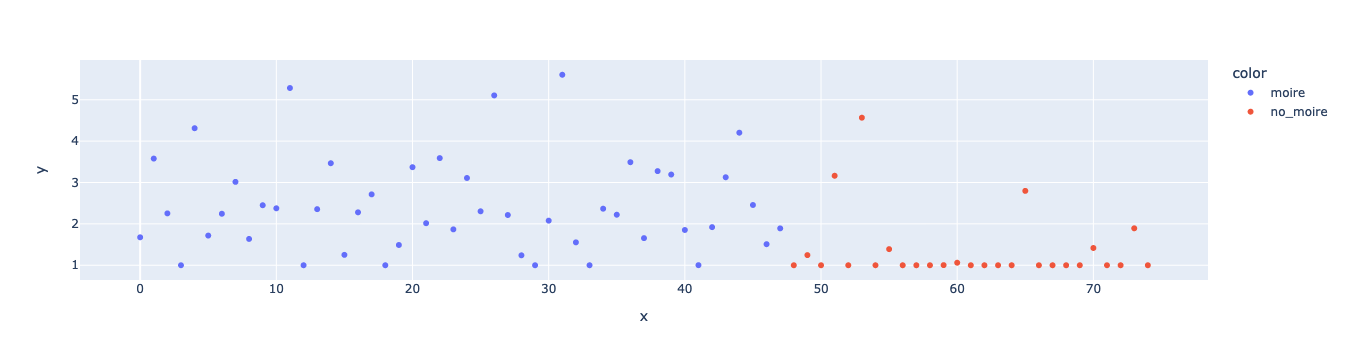

In [759]:
px.scatter(
    y=[m[3] for m in out_moire] + [m[3] for m in out_no_moire],
    color=['moire' for m in out_moire] + ['no_moire' for m in out_no_moire],
)

In [656]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.preprocessing import LabelEncoder

In [760]:
X = [(m[3],m[5]) for m in out_moire] + [(m[3],m[5]) for m in out_no_moire]
y = [0 for m in out_moire] + [1 for m in out_no_moire]

In [763]:
idx = [i for i in range(len(X))]
shuffle(idx)

In [764]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(
    [X[i] for i in idx[:35]],
    [y[i] for i in idx[:35]]
)

DecisionTreeClassifier(random_state=0)

In [765]:
prediction = clf.predict(
    [X[i] for i in idx[35:]],
    [y[i] for i in idx[35:]]
)

In [769]:
clf.score(
    [X[i] for i in idx[35:]],
    [y[i] for i in idx[35:]]
)

0.675

In [778]:
[y[i] for i in idx[35:]][15:25]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [779]:
prediction[15:25]

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1])

In [766]:
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(idx[35:])):
    label = y[idx[i]]
    pred = prediction[i]

    if label == pred:
        if label == 0:
            TP += 1
        else:
            TN += 1
    else:
        if label == 0:
            FN += 1
        else:
            FP += 1

In [767]:
TP, TN, FP, FN

(15, 5, 11, 9)